# Neural Networks
Tensorflow is the deep learning library of Google. It became available a couple of years ago and has seen several releases since then. Recently, `keras`, a famous wrapper that supports several deep learning libraries, has also been integrated to tensorflow. Since it is much easier to use keras, we are going to use it in this class. You can find the [documentation](https://www.tensorflow.org/) of Tensorflow along with some examples in the link. Note that keras is not a deep learning library. It still needs a deep learning library at the backend (one or more of Tensorflow, Microsoft CNTK, Theano).

We use [bank marketing](https://archive.ics.uci.edu/ml/datasets/bank+marketing) data set und the UCI Machine Learning Repository. The objective is to use customer and demographic data to predict customer response for marketing campaigns. During the course we are going to do the following:
* Read the data set and convert categorical features to dummies (Note that keras requires onehot encoding for categorical features).
* Scale the dataset
* Run a simple neural network.
* Optimize the parameters of the neural network
* Select the best model using Neural Networks and Gradient Boosting algorithm of LightGBM.

We start by reading the data and introducing the missing values in the `pdays` column.

In [15]:
#Standart packages.
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score
import matplotlib.pyplot as plt
import numpy as np


# To shut down warning messages
import warnings
warnings.filterwarnings("ignore")

df = pd.read_csv('bank-additional-full.csv', delimiter=';')
y= (df['y'] == 'yes')*1
df.drop('y', axis=1, inplace = True)
df.drop('duration', inplace = True, axis=1)
df['pdays'].replace(999, np.NaN, inplace = True)
df.describe()

,age,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,41188.00000,41188.000000,1515.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,2.567593,6.014521,0.172963,0.081886,93.575664,-40.502600,3.621291,5167.035911
std,10.42125,2.770014,3.824906,0.494901,1.570960,0.578840,4.628198,1.734447,72.251528
min,17.00000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.00000,1.000000,3.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.00000,2.000000,6.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.00000,3.000000,7.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,98.00000,56.000000,27.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


Here is a small summary of the meanings of the columns, which you can also find in the [UCI Repository](https://archive.ics.uci.edu/ml/datasets/bank+marketing):
* age: Age.
* job: Job definition.
* marital: Marital status.
* education: Education.
* default: Has the customer defaulted?
* housing: Is the customer paying housing loan?
* loan: Is the customer paying other loans?
* contact: Prefered communication channel of the customer.
* month: The month of last contact.
* day_of_week: Day of the week of the last contact. 
* duration: The length of the last contact (0 means that the label is also 0 so we have to delete the column for avoiding data leakage).
* campaign: Number of communications made with the customer for the campaign.
* pdays: The number of days since the last contact for the campaign. 999 means no communication. 
* previous: Number of contacts with the customer.
* poutcome: Outcome of the previous communication.                     
* emp.var.rate: The variation in the unemployment rate.
* cons.pric.idx: Consumer price index.
* cons.conf.idx: Consumer confidence index.
* euribor3m: Euribor interest rate (Euro Interbank Offered Rate).
* nr.employed: Number of employed people.

The last five features are given for the time period of the campaign. They are features related to the economic conditions at the time of the campaign. 

Let us check whether there is missing data.

In [16]:
print(df.isnull().sum())

age                   0
job                   0
marital               0
education             0
default               0
housing               0
loan                  0
contact               0
month                 0
day_of_week           0
campaign              0
pdays             39673
previous              0
poutcome              0
emp.var.rate          0
cons.price.idx        0
cons.conf.idx         0
euribor3m             0
nr.employed           0
dtype: int64


It is a good practice to keep the information the the value is missing and has been imputed somehow. Let us introduce a new column named `pdays_missing`. 

In [17]:
#Add a column to show that pdays value is missing
df['pdays_missing'] = .............
df[['pdays', 'pdays_missing']].describe()

,pdays,pdays_missing
count,1515.000000,41188.000000
mean,6.014521,0.963217
std,3.824906,0.188230
min,0.000000,0.000000
25%,3.000000,1.000000
50%,6.000000,1.000000
75%,7.000000,1.000000
max,27.000000,1.000000


Next, we are going to split the dataframe for training and testing.

In [18]:
df_train, df_test, y_train, y_test = train_test_split(df, y, train_size = 0.7, test_size = 0.3, random_state = 0)

There are two steps to follow before we study neural networks:
* Convert categorical variables into dummies,
* Scale the relevant variables.

To convert the variables, I am going to use `get_dummies` from pandas

In [19]:
columns_to_dummy =['job', 'marital', 'education', 'default',
                  'housing', 'loan', 'contact', 'month',
                  'day_of_week', 'poutcome']

df_train = ..............
print(np.shape(df_train))

df_test = ................
print(np.shape(df_test))

(28831, 63)
(12357, 63)


This time, we were lucky and the two data frames have the same set of columns. If this was not true, we could have used `align` to align the two dataframes.

In [20]:
# You can try and drop a column from the test dataframe, it will still
# have the same number of columns when this code runs
# df_test2.drop('age', inplace = True, axis=1)

df_train, df_test = df_train.align(df_test, join='outer', axis=1, fill_value=0)

print(np.shape(df_train))

print(np.shape(df_test))


(28831, 63)
(12357, 63)


Let us see a list of the columns of the dataframes:

In [21]:
for i in df_train.columns:
    print(i)

age
campaign
pdays
previous
emp.var.rate
cons.price.idx
cons.conf.idx
euribor3m
nr.employed
pdays_missing
job_admin.
job_blue-collar
job_entrepreneur
job_housemaid
job_management
job_retired
job_self-employed
job_services
job_student
job_technician
job_unemployed
job_unknown
marital_divorced
marital_married
marital_single
marital_unknown
education_basic.4y
education_basic.6y
education_basic.9y
education_high.school
education_illiterate
education_professional.course
education_university.degree
education_unknown
default_no
default_unknown
default_yes
housing_no
housing_unknown
housing_yes
loan_no
loan_unknown
loan_yes
contact_cellular
contact_telephone
month_apr
month_aug
month_dec
month_jul
month_jun
month_mar
month_may
month_nov
month_oct
month_sep
day_of_week_fri
day_of_week_mon
day_of_week_thu
day_of_week_tue
day_of_week_wed
poutcome_failure
poutcome_nonexistent
poutcome_success


Just one more step before we start with neural networks. Neural networks are sensitive to scale (both in terms of performance and the computation time). For this reason it is a good practice to scale the variables. You can use StandardScaler (to create a normal distribution with mean 0 and std 1) or use MinMaxScaler to convert the variables to values between 0 and 1. Note that we do not need to do this for dummy columns or the column contains an already scaled value (such as a percentage).

Note that by scaling the variables to a standard normal distribution, we assure that the mean is equal to 0. This is what we are going to use for filling the missing values in `pdays` column.

In [22]:
cols_to_scale = ['age',
'campaign',
'pdays',
'previous',
'emp.var.rate',
'cons.price.idx',
'cons.conf.idx',
'euribor3m',
'nr.employed']

from sklearn.preprocessing import StandardScaler

ssc = ................


#Scale the training and testing datatset
................................


df_train['pdays'].fillna(0, inplace = True)
df_test['pdays'].fillna(0, inplace = True)

# Creating the Neural Network

`Tensorflow` can use several types of layers. We are going to use Dense networks in this case. Dense networks are mostly compatible with 2D matrices.

To create the model we are going to use the `Sequential API`. This allows us create sequential models (in which one layer takes as input the outputs of the previous layer).

We create a simple network of one layer and one node. The second layer will be the output layer and will use the sigmoid activation function.

In [23]:
# import Tensorflow and Keras
import tensorflow as tf

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras import backend as K 

K.clear_session()
model = .................
model...................
model..................

# Compile model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
 
# Fit the model
model.fit(df_train, np.asarray(y_train).astype(np.float32), epochs=..........., batch_size=............, verbose =2)

901/901 - 1s - loss: 0.3416 - accuracy: 0.8703


Let us now see the performance.

In [29]:
y_pred_proba = model.predict(df_test)

y_pred = model.predict_classes(df_test)

print(accuracy_score(y_test,y_pred))
print(roc_auc_score(y_test, y_pred_proba))

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
0.8974670227401473
0.7554068079731115


This model is basically logistic regression (apart from some details such as regularization). As you can see their performance is quite similar.

In [30]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(df_train, y_train)

y_pred_proba = lr.predict_proba(df_test)[:,1]

y_pred = lr.predict(df_test)

print(accuracy_score(y_test,y_pred))
print(roc_auc_score(y_test, y_pred_proba))

0.8989236869790402
0.7890312047864521


As such neural networks look quite similar to logistic regression (or linear regression if you use linear activation function at the end).

The power of neural networks come from the fact that they can model nonlinear relationships. To model nonlinear relationships you require 2 components:
* more layers or hidden units (nodes)
* activation functions. Even functions such as relu can help you understand nonlinear relationships.

We illustrate this on an artificial data set.

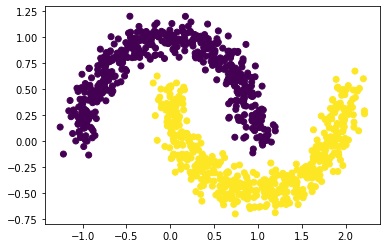

In [31]:
from sklearn.datasets import make_moons

X,y = make_moons(1000, noise = 0.1)

import matplotlib.pyplot as plt

plt.scatter(X[:,0], X[:,1], c= y)
plt.show()

The first step is to create a network of two layers (without any activation function). You will see that this does not help us create a successful model and we will need activation functions as well.

In [32]:
# import Tensorflow and Keras
import tensorflow as tf

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras import backend as K 

K.clear_session()
model = Sequential()
model.add(Dense(20, input_dim=np.shape(X)[1]))#, activation='relu'))
model.add(Dense(20))#, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compile model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Fit the model
model.fit(X, y, epochs=100, batch_size=16, verbose =2)

Epoch 1/100
63/63 - 0s - loss: 0.4664 - accuracy: 0.8220
Epoch 2/100
63/63 - 0s - loss: 0.3049 - accuracy: 0.8590
Epoch 3/100
63/63 - 0s - loss: 0.2684 - accuracy: 0.8760
Epoch 4/100
63/63 - 0s - loss: 0.2569 - accuracy: 0.8820
Epoch 5/100
63/63 - 0s - loss: 0.2520 - accuracy: 0.8850
Epoch 6/100
63/63 - 0s - loss: 0.2515 - accuracy: 0.8830
Epoch 7/100
63/63 - 0s - loss: 0.2506 - accuracy: 0.8830
Epoch 8/100
63/63 - 0s - loss: 0.2503 - accuracy: 0.8830
Epoch 9/100
63/63 - 0s - loss: 0.2504 - accuracy: 0.8880
Epoch 10/100
63/63 - 0s - loss: 0.2509 - accuracy: 0.8850
Epoch 11/100
63/63 - 0s - loss: 0.2513 - accuracy: 0.8870
Epoch 12/100
63/63 - 0s - loss: 0.2502 - accuracy: 0.8830
Epoch 13/100
63/63 - 0s - loss: 0.2503 - accuracy: 0.8850
Epoch 14/100
63/63 - 0s - loss: 0.2502 - accuracy: 0.8870
Epoch 15/100
63/63 - 0s - loss: 0.2500 - accuracy: 0.8830
Epoch 16/100
63/63 - 0s - loss: 0.2505 - accuracy: 0.8820
Epoch 17/100
63/63 - 0s - loss: 0.2502 - accuracy: 0.8860
Epoch 18/100
63/63 - 0s

Let us see the results and the decision boundaries.

Accuracy:  0.883


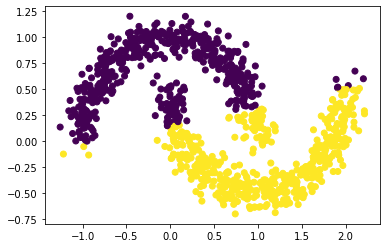

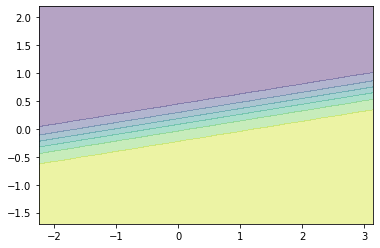

In [33]:
y_pred = model.predict_classes(X)

print('Accuracy: ',accuracy_score(y,y_pred.ravel()))

plt.scatter(X[:,0], X[:,1], c= y_pred.ravel())
plt.show()

# Plotting decision regions
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))


Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.contourf(xx, yy, Z, alpha=0.4)

plt.show()

In [34]:
# import Tensorflow and Keras
import tensorflow as tf

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras import backend as K 

K.clear_session()
model = Sequential()
#Add activation function
model.add(Dense(20, input_dim=np.shape(X)[1], ..........))
model.add(Dense(20, ...............))
model.add(Dense(1, activation='sigmoid'))

# Compile model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Fit the model
model.fit(X, y, epochs=100, batch_size=16, verbose =2)

Epoch 1/100
63/63 - 0s - loss: 0.5952 - accuracy: 0.8460
Epoch 2/100
63/63 - 0s - loss: 0.4335 - accuracy: 0.8560
Epoch 3/100
63/63 - 0s - loss: 0.3207 - accuracy: 0.8710
Epoch 4/100
63/63 - 0s - loss: 0.2750 - accuracy: 0.8780
Epoch 5/100
63/63 - 0s - loss: 0.2514 - accuracy: 0.8820
Epoch 6/100
63/63 - 0s - loss: 0.2368 - accuracy: 0.8930
Epoch 7/100
63/63 - 0s - loss: 0.2246 - accuracy: 0.8910
Epoch 8/100
63/63 - 0s - loss: 0.2122 - accuracy: 0.9020
Epoch 9/100
63/63 - 0s - loss: 0.1994 - accuracy: 0.9030
Epoch 10/100
63/63 - 0s - loss: 0.1892 - accuracy: 0.9110
Epoch 11/100
63/63 - 0s - loss: 0.1786 - accuracy: 0.9160
Epoch 12/100
63/63 - 0s - loss: 0.1667 - accuracy: 0.9210
Epoch 13/100
63/63 - 0s - loss: 0.1578 - accuracy: 0.9270
Epoch 14/100
63/63 - 0s - loss: 0.1484 - accuracy: 0.9340
Epoch 15/100
63/63 - 0s - loss: 0.1374 - accuracy: 0.9370
Epoch 16/100
63/63 - 0s - loss: 0.1268 - accuracy: 0.9470
Epoch 17/100
63/63 - 0s - loss: 0.1168 - accuracy: 0.9560
Epoch 18/100
63/63 - 0s

It seems like we have created a perfect model. 

Accuracy:  1.0


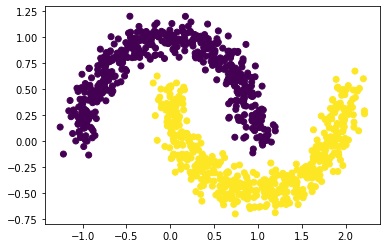

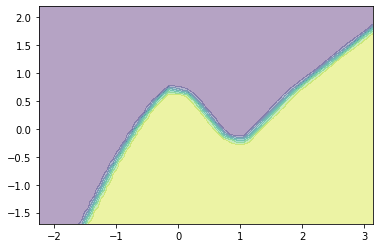

In [35]:
y_pred = model.predict_classes(X)

print('Accuracy: ',accuracy_score(y,y_pred.ravel()))

plt.scatter(X[:,0], X[:,1], c= y_pred.ravel())
plt.show()

# Plotting decision regions
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))


Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.contourf(xx, yy, Z, alpha=0.4)

plt.show()

Now let us apply this knowledge to our problem, by creating a network of 3 layers with 100 hidden units each.

In [36]:
# import Tensorflow and Keras
import tensorflow as tf

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras import backend as K 

K.clear_session()
model = Sequential()
model.add(Dense(100, input_dim=np.shape(df_train)[1], activation='relu'))
model.add(Dense(100, activation='relu'))
model.add(Dense(100, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compile model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Fit the model
model.fit(df_train, np.asarray(y_train).astype(np.float32), epochs=100, batch_size=32, verbose =2)

Epoch 1/100
1802/1802 - 4s - loss: 0.2863 - accuracy: 0.8971
Epoch 2/100
1802/1802 - 5s - loss: 0.2766 - accuracy: 0.8993
Epoch 3/100
1802/1802 - 5s - loss: 0.2738 - accuracy: 0.9010
Epoch 4/100
1802/1802 - 4s - loss: 0.2711 - accuracy: 0.9024
Epoch 5/100
1802/1802 - 3s - loss: 0.2680 - accuracy: 0.9036
Epoch 6/100
1802/1802 - 4s - loss: 0.2643 - accuracy: 0.9049
Epoch 7/100
1802/1802 - 4s - loss: 0.2615 - accuracy: 0.9057
Epoch 8/100
1802/1802 - 3s - loss: 0.2569 - accuracy: 0.9086
Epoch 9/100
1802/1802 - 3s - loss: 0.2521 - accuracy: 0.9085
Epoch 10/100
1802/1802 - 3s - loss: 0.2486 - accuracy: 0.9110
Epoch 11/100
1802/1802 - 4s - loss: 0.2441 - accuracy: 0.9124
Epoch 12/100
1802/1802 - 4s - loss: 0.2389 - accuracy: 0.9143
Epoch 13/100
1802/1802 - 3s - loss: 0.2332 - accuracy: 0.9170
Epoch 14/100
1802/1802 - 3s - loss: 0.2274 - accuracy: 0.9194
Epoch 15/100
1802/1802 - 4s - loss: 0.2224 - accuracy: 0.9213
Epoch 16/100
1802/1802 - 3s - loss: 0.2139 - accuracy: 0.9241
Epoch 17/100
1802

Next, we evaluate the model using the testing dataset.

In [37]:
y_pred_proba = model.predict(df_test)

y_pred = model.predict_classes(df_test)

print(accuracy_score(y_test,y_pred))
print(roc_auc_score(y_test, y_pred_proba))

0.8696285506190823
0.6608788180365783


We see a classic example of overfitting. Luckily, neural networks contain a layer type, called `Dropout`, to avoid overfitting. Dropout layers silences some of the nodes in a layer randomly at each iteration to avoid overfitting.

We add Dropout layers after the Dense layers with a dropout rate of 20%.

In [38]:
from sklearn.metrics import roc_auc_score
K.clear_session()
model = Sequential()
model.add(Dense(100, input_dim=np.shape(df_train)[1], activation='relu'))
..............
model.add(Dense(100, activation='relu'))
............
model.add(Dense(100, activation='relu'))
.............
model.add(Dense(1, activation='sigmoid'))

# Compile model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


# Fit the model
model.fit(df_train, np.asarray(y_train).astype(np.float32), epochs=100, batch_size=16, verbose =2)

y_pred_proba = model.predict(df_test)

y_pred = model.predict_classes(df_test)

print(accuracy_score(y_test,y_pred))
print(roc_auc_score(y_test, y_pred_proba))

Epoch 1/100
1802/1802 - 4s - loss: 0.3160 - accuracy: 0.8893
Epoch 2/100
1802/1802 - 4s - loss: 0.2961 - accuracy: 0.8958
Epoch 3/100
1802/1802 - 4s - loss: 0.2911 - accuracy: 0.8965
Epoch 4/100
1802/1802 - 3s - loss: 0.2902 - accuracy: 0.8974
Epoch 5/100
1802/1802 - 3s - loss: 0.2862 - accuracy: 0.8980
Epoch 6/100
1802/1802 - 4s - loss: 0.2851 - accuracy: 0.8981
Epoch 7/100
1802/1802 - 3s - loss: 0.2818 - accuracy: 0.8976
Epoch 8/100
1802/1802 - 4s - loss: 0.2822 - accuracy: 0.8976
Epoch 9/100
1802/1802 - 4s - loss: 0.2804 - accuracy: 0.8973
Epoch 10/100
1802/1802 - 5s - loss: 0.2802 - accuracy: 0.8987
Epoch 11/100
1802/1802 - 5s - loss: 0.2806 - accuracy: 0.8979
Epoch 12/100
1802/1802 - 4s - loss: 0.2779 - accuracy: 0.8992
Epoch 13/100
1802/1802 - 5s - loss: 0.2794 - accuracy: 0.8981
Epoch 14/100
1802/1802 - 5s - loss: 0.2781 - accuracy: 0.8989
Epoch 15/100
1802/1802 - 4s - loss: 0.2784 - accuracy: 0.8994
Epoch 16/100
1802/1802 - 4s - loss: 0.2759 - accuracy: 0.9004
Epoch 17/100
1802

Dropout has prevented overfitting to some extent, we could play with the dropout rate to see its effect.

# Model optimization and Model Selection using Cross-Validated Grid Search

It is still possible to use Scikit-Learn API even when you are using the keras library.

We are going to perform a grid search of neural network parameters. We will do the same thing for a lightgbm model and create one single model based on the performances of our tests.

* The grid search consists of dividing the data set into 3 partitions (folds). We use two folds for training the models with the given parameters and use the third fold for getting the results (here we use area under curve).
* We apply grid search to test the neural network parameters.
* We apply grid search to test for lightgbm parameters.
* We take the best performing model and parameters as the champion.
* The champion model / parameters are trained one final time using the whole training data set.
* The model is used for predicting the results in the test data set.
* Note that the test data set is used only once at the very end.

In [39]:
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

# Function to create model, required for KerasClassifier
def create_model(neurons=1, dropout_rate=0.2, layers = 2):
    # create model
    model = Sequential()
    model.add(Dense(neurons, input_dim=53, activation = 'relu'))
    model.add(Dropout(dropout_rate))
    for i in range(layers-1):
        model.add(Dense(neurons, activation = 'relu'))
        model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model


model = KerasClassifier(build_fn=create_model, verbose=0)
# define the grid search parameters
neurons = [10]#, 20]
dropout_rate = [0.2]#, 0.5]
epochs = [20]#, 50]
layers = [1,2]
batch_size = [16]
param_grid = dict(neurons=neurons, epochs = epochs, 
                  batch_size = batch_size, dropout_rate = dropout_rate,
                 layers=layers)


grid = GridSearchCV(.................., n_jobs=2, verbose = 1, scoring= 'roc_auc')
grid_result = grid.fit(df_train, y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
    
    
    

Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:  4.5min finished


Best: 0.790189 using {'batch_size': 16, 'dropout_rate': 0.2, 'epochs': 20, 'layers': 1, 'neurons': 10}
0.790189 (0.013308) with: {'batch_size': 16, 'dropout_rate': 0.2, 'epochs': 20, 'layers': 1, 'neurons': 10}
0.786519 (0.010911) with: {'batch_size': 16, 'dropout_rate': 0.2, 'epochs': 20, 'layers': 2, 'neurons': 10}


The area under curve is around 0.79. Let us see whether we can improve it using the `lightgbm` package.

In [40]:
import lightgbm as lgb

# Create training data set.
lgb_train = lgb.Dataset(data=df_train, label=y_train,  free_raw_data=False)

# Create parameters to search
gridParams = {
    'learning_rate': [0.005, 0.01],
    'n_estimators': [50, 100],
    'boosting_type' : ['gbdt'],
    'objective' : ['binary'],
    'random_state' : [0]}

# Create classifier to use. Note that parameters have to be input manually
# not as a dict!
lgb_model = lgb.LGBMClassifier(boosting_type= 'gbdt',
          objective = 'binary',
          silent = True)


# Create the grid
grid = GridSearchCV(lgb_model, gridParams, scoring= 'roc_auc', verbose=0)

grid.fit(df_train,y_train)

print("Best: %f using %s" % (grid.best_score_, grid.best_params_))


Best: 0.796374 using {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'n_estimators': 100, 'objective': 'binary', 'random_state': 0}


# Training the Final Model

The best model is now selected. We are going to use lightgbm package with the following parameters:
* learning_rate: 0.01
* n_estimators: 100

However, we should create a model with the given parameters and train it using the whole training dataset. It is always a better practice to train one final model using the whole data set. Why should you not use the data that you have?

In [41]:
lgb_final_model = grid.best_estimator_

lgb_final_model.fit(df_train,y_train)


y_pred = lgb_final_model.predict_proba(df_test)

print('AUC:', roc_auc_score(y_test, y_pred[:,1]))
print('Accuracy:', accuracy_score(y_test, ( y_pred[:,1]>= 0.5)*1))

AUC: 0.8018400624973233
Accuracy: 0.8969005422028


Notice that we only used the test data set once, at the very end. This helps us avoid overfitting the parameters to the test dataset. It is possible to do so even if you are not using the test data set for training.

# What would you do if the model performed badly on the testing data set?

# Optimizers

The optimization of neural networks can be the most important step in your predictive model. Optimization parameters like the learning rate (remember the step size for the gradient descent algorithm) may allow you to converge to a good solution quickly or can guide your network parameters to solutions quite far from the optimum.

It is a good practice to start with a large learning rate (usually 0.1 or 0.01) and reduce the learning rate when your optimization algorithm cannot improve the model performance for some epochs.To evaluate the model performance you will need an evaluation data set (different from the test data set). However, for sake of simplicity I use the test data set in the following example.

I use ReduceLROnPlateau to reduce the learning rate by a factor (parameter) after a number of iterations without improvement (called patience). We also save the best model by using a ModelCheckpoint.

In [44]:
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import ReduceLROnPlateau,ModelCheckpoint

K.clear_session()
model = Sequential()
model.add(Dense(10, input_dim=np.shape(df_train)[1], activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

adam_1 = optimizers.Adam(lr=0.1)


# Compile model
model.compile(loss='binary_crossentropy', optimizer=adam_1)

#ReduceLROnPlateau : 
# If there is no improvement after 5 epochs we reduce the learning rate by a factor of 0.1
# Bununla önce modelin hızlı öğrenmesi sağlanıyor eğer 5 epoch boyunca iyileşme olmazsa learning rate 0.1 ile çarpılıyor (min learning rate değerine gelene kadar) 
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,patience=5, min_lr=1e-4,verbose = 1)

model_path = 'Best_model.h5'
model_cp = ModelCheckpoint(model_path, monitor='val_loss', verbose=1, save_best_only = True)

history_1 = model.fit(x = df_train,y = np.asarray(y_train).astype(np.float32),validation_data =(df_test, np.asarray(y_test).astype(np.float32)), epochs = 40,
                        batch_size = 16,verbose=2, callbacks=[reduce_lr, model_cp])

Epoch 1/40

Epoch 00001: val_loss improved from inf to 0.35142, saving model to Best_model.h5
1802/1802 - 3s - loss: 0.3605 - val_loss: 0.3514
Epoch 2/40

Epoch 00002: val_loss did not improve from 0.35142
1802/1802 - 3s - loss: 0.3553 - val_loss: 0.3522
Epoch 3/40

Epoch 00003: val_loss did not improve from 0.35142
1802/1802 - 3s - loss: 0.3610 - val_loss: 0.3517
Epoch 4/40

Epoch 00004: val_loss did not improve from 0.35142
1802/1802 - 3s - loss: 0.3540 - val_loss: 0.3529
Epoch 5/40

Epoch 00005: val_loss did not improve from 0.35142
1802/1802 - 3s - loss: 0.3544 - val_loss: 0.3516
Epoch 6/40

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.010000000149011612.

Epoch 00006: val_loss did not improve from 0.35142
1802/1802 - 3s - loss: 0.3547 - val_loss: 0.3523
Epoch 7/40

Epoch 00007: val_loss improved from 0.35142 to 0.35137, saving model to Best_model.h5
1802/1802 - 3s - loss: 0.3526 - val_loss: 0.3514
Epoch 8/40

Epoch 00008: val_loss did not improve from 0.35137
1802/18